In [99]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.layers import Dense,Bidirectional,LSTM,Embedding,Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import nltk
from sklearn.model_selection import train_test_split

In [100]:
df = pd.read_csv('/Users/benjamin.guigon/Desktop/PSB/Semestre 1/Python/Perso/IMDB/IMDB Dataset.csv')
df = df.head(5000)

In [101]:
# Replacing Positive -> 1 and Negative -> 0
df.replace({"positive":1,"negative":0},inplace=True)

In [102]:
X = df.iloc[:,0].values
y = df.iloc[:,1].values

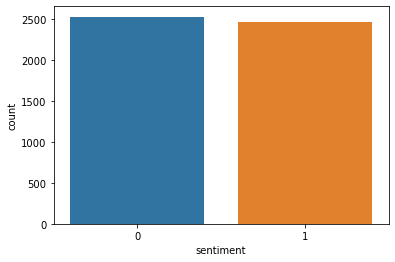

In [103]:
# Checking Data Balance

sns.countplot(x="sentiment",data=df)

In [104]:
# Making datasets to visualise
df["len"] = np.array([len(i) for i in X])

neg = df.where(df["sentiment"]==0).dropna().reset_index().drop(["index"],axis=1)
pos = df.where(df["sentiment"]==1).dropna().reset_index().drop(["index"],axis=1)

In [105]:
df

,review,sentiment,len
0,One of the other reviewers has mentioned that ...,1,1761
1,A wonderful little production. <br /><br />The...,1,998
2,I thought this was a wonderful way to spend ti...,1,926
3,Basically there's a family where a little boy ...,0,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,1317
...,...,...,...
4995,An interesting slasher film with multiple susp...,0,689
4996,i watched this series when it first came out i...,1,1862
4997,Once again Jet Li brings his charismatic prese...,1,1457
4998,"I rented this movie, after hearing Chris Gore ...",0,3424


In [106]:
STOPWORDS = list(STOPWORDS)
STOPWORDS.append("br")

In [107]:
# Function to plot wordcloud
def plot_wordcloud(data):
    words = '' 
    stopwords = set(STOPWORDS) 
    for val in data.values: 
        val = str(val) 
        tokens = val.split() 
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower() 

        words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(words)                        
    plt.figure(figsize = (20,16), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)
    plt.show()

In [108]:
#plot_wordcloud(pos["review"])

In [109]:
#plot_wordcloud(neg["review"])

In [117]:
# Creating Tokeniser
tkn = tf.keras.preprocessing.text.Tokenizer(
    num_words=None,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    oov_token="{OOV}"
)
# Tokenising Train Data
tkn.fit_on_texts(X)

In [111]:
# Length Of Word Index
len(tkn.word_index)

43343

In [81]:
X = tkn.texts_to_sequences(X)
X = tf.keras.preprocessing.sequence.pad_sequences(X,maxlen=200)

In [92]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [93]:
# Splitting Data into Train and [test+val]
#x_train = X[:4000]
#y_train = y[:4000]
#x_val = X[4000:]
#y_val = y[4000:]

In [94]:
# Splitting data into Validation and Test
#x_test = x_val[:500]
#y_test = y_val[:500]
#x_val = x_val[5000:]
#y_val = y_val[5000:]

In [95]:
# Input for variable-length sequences of integers
inputs = Input(shape=(None,), dtype="int32")

# Embed each integer in a 128-dimensional vector
x = Embedding(len(tkn.word_index), 200)(inputs)

# Add 2 bidirectional LSTMs
x = Bidirectional(LSTM(30,return_sequences=True))(x)
x = Bidirectional(LSTM(30,return_sequences=True))(x)
x = Bidirectional(LSTM(20,return_sequences=True))(x)
x = Bidirectional(LSTM(20,return_sequences=True))(x)
x = Bidirectional(LSTM(10,return_sequences=True))(x)
x = Bidirectional(LSTM(10))(x)

# Add a classifier
outputs = Dense(1, activation="sigmoid")(x)
model = Model(inputs, outputs)
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_5 (Embedding)      (None, None, 200)         8668600   
_________________________________________________________________
bidirectional_30 (Bidirectio (None, None, 60)          55440     
_________________________________________________________________
bidirectional_31 (Bidirectio (None, None, 60)          21840     
_________________________________________________________________
bidirectional_32 (Bidirectio (None, None, 40)          12960     
_________________________________________________________________
bidirectional_33 (Bidirectio (None, None, 40)          9760      
_________________________________________________________________
bidirectional_34 (Bidirectio (None, None, 20)          4080

In [96]:
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=32, epochs=2)#, validation_data=(x_val, y_val))

Epoch 1/2
125/125 [==============================] - 48s 299ms/step - loss: 0.6802 - accuracy: 0.5596
Epoch 2/2
125/125 [==============================] - 39s 314ms/step - loss: 0.3892 - accuracy: 0.8630
